# International football results from 1872 to 2017 

This dataset is provided by MartJ on [Kaggle](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017).

## Content

This dataset includes 38,361 results of international football matches starting from the very first official math in 1872 up to 2017. The matches range from World Cup to Baltic Cup to regular friendly matches. The matches are strictly men's full internationals and the data do not include Olympic Games or matches where at least one of the teams was the nation's B-team, U-23 or a league select team.

It includes the following columns:
* `date`: the date the match has been played;
* `home_team`: the team which played at home;
* `away_team`: the team which played away;
* `home_score`: the score for the home team;
* `away_score`: the score for the away team;
* `tournament`: friendly, world cup, copa america, etc;
* `city`: the city where the match has been played;
* `country`: the country where the match has been played;
* `neutral`: TRUE/FALSE column indicating whether the match was played at a neutral venue.

## Acknowledgements

The data is gathered from several sources including but not limited to wikipedia.com, fifa.com, rsssf.com and individual football associations' websites.

## Code

The entire code of this analysis is on my [Github](https://github.com/StevenGolovkine/internationalFootballResults) repository.

-----

## Load the used libraries 

In [157]:
get_ipython().magic('matplotlib inline')

from flatten_json import flatten
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

## Define functions

In [2]:
def convert_date(data, column):
    date = pd.DataFrame(data[column].apply(lambda x: {'year': x.split('-')[0], 'month': x.split('-')[1], 'day': x.split('-')[2]}))
    dic = pd.DataFrame(date.values.tolist())[0]
    df = pd.DataFrame(flatten(d) for d in dic)
    return df

## Import the data

In [51]:
results = pd.read_csv("results.csv", sep=',', header=0)
results =  results.replace({'Germany DR': 'Germany', 'China': 'China PR'})

In [52]:
# Let's look at the data
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [53]:
# Create columns with day, month and year
results = pd.concat([results, convert_date(results, 'date')], axis=1)
results['date'] = pd.to_datetime(results['date'])

In [54]:
# Do the data have missing/null values?
print("There is", results.isna().sum().sum(), "missing value.")
print("There is", results.isnull().sum().sum(), "null value.")

There is 0 missing value.
There is 0 null value.


In [55]:
print("Since ", results.date[0], ", there were ", len(results), " international football matches (until ", results.date[len(results) - 1], ").", sep='')

Since 1872-11-30 00:00:00, there were 39008 international football matches (until 2018-06-04 00:00:00).


## Exploration of the data

* #### Which country played the most? 

In [56]:
count_match_home = results.home_team.value_counts()
count_match_away = results.away_team.value_counts()
count_match = pd.DataFrame([count_match_home, count_match_away]).transpose().fillna(0)
count_match['total'] = count_match.home_team + count_match.away_team
count_match = count_match.sort_values('total', ascending=False)

Quite surprisingly, Sweden played the most games since the data are recorded. Swedish are followed by four important football nation: England (who made the rules), Argentina (who are one of the most titles in Copa América), Brazil (who are the most titles in World Cup) and Germany (who are one of the most titles in European Cup).

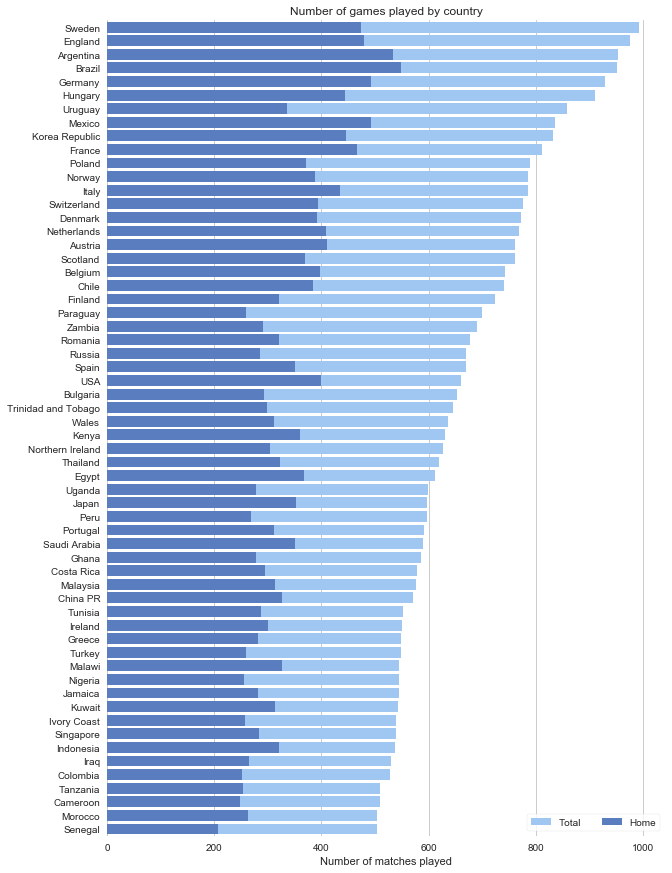

In [57]:
count_match_display = count_match[count_match.total > 500]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x='total', y=count_match_display.index, data=count_match_display, label='Total', color='b')

# Plot the home match 
sns.set_color_codes("muted")
sns.barplot(x="home_team", y=count_match_display.index, data=count_match_display, label='Home', color='b')

# Add legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_title("Number of games played by country")
ax.set(xlabel="Number of matches played")
sns.despine(left=True, bottom=True)

* #### Which country won the most?

In [58]:
winner = pd.Series(np.zeros(len(results)))

for idx in results.index:
    if results.home_score.iloc[idx] > results.away_score.iloc[idx] :
        winner.iloc[idx] = results.home_team.iloc[idx]
    elif results.home_score.iloc[idx] < results.away_score.iloc[idx] :
        winner.iloc[idx] = results.away_team.iloc[idx]
    else :
        winner.iloc[idx] = None
        
count_win = pd.DataFrame(winner.value_counts(), columns=['Win'])

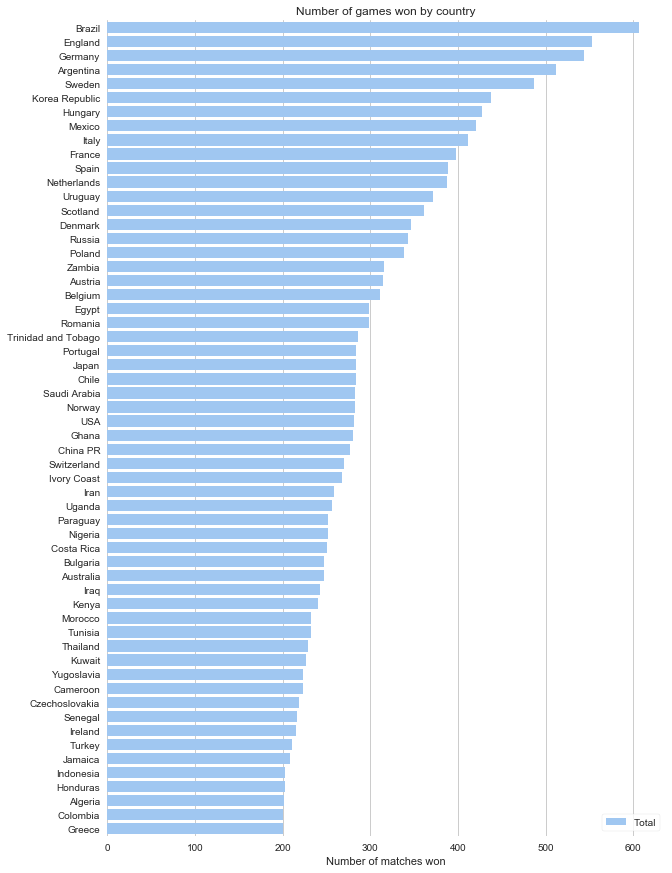

In [59]:
count_win_display = count_win[count_win > 200].dropna()

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x='Win', y=count_win_display.index, data=count_win_display, label='Total', color='b')

# Add legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set_title("Number of games won by country")
ax.set(xlabel="Number of matches won")
sns.despine(left=True, bottom=True)

Mechanically, we find the same teams in the most played graph and in the most won graph (of course, the more you played, the more you have possibility to have a high number of win). But what if we look at the winning percentage ? First, only around 20 countries have a winning percentage greater than 50%. Second, some "classical" countries are on top of the ranking but we also see some smaller countries like Jersey, Northern Cyprus, Iran ...

In [60]:
winner_percent = pd.DataFrame(count_win['Win'] / pd.DataFrame(count_match['total'])['total'], columns=['Percent'])

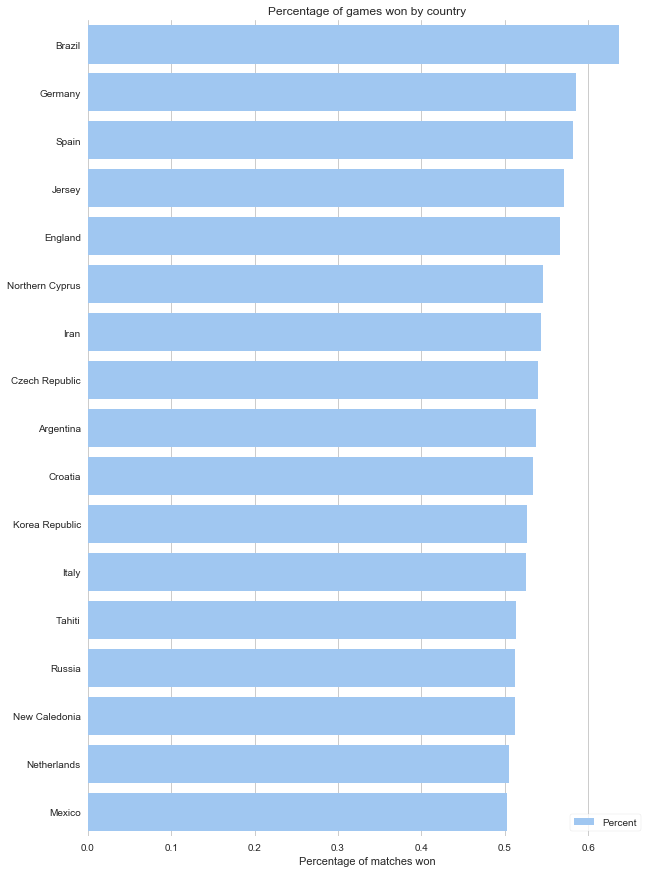

In [61]:
percent_win_display = winner_percent[winner_percent > 0.5].dropna().sort_values(by='Percent', ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x='Percent', y=percent_win_display.index, data=percent_win_display, label='Percent', color='b')

# Add legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set_title("Percentage of games won by country")
ax.set(xlabel="Percentage of matches won")
sns.despine(left=True, bottom=True)

* #### Which countries played the most into international tournaments?

If we do not consider friendly matches, the number of games played in the context of FIFA World Cup qualification is the most important. In fact, it is three times higher than for the UEFA Euro qualification. One reason that could explain that is that almost every countries in the world can play the World Cup qualification. 

In [62]:
tournament_play = pd.DataFrame(results.tournament.value_counts())

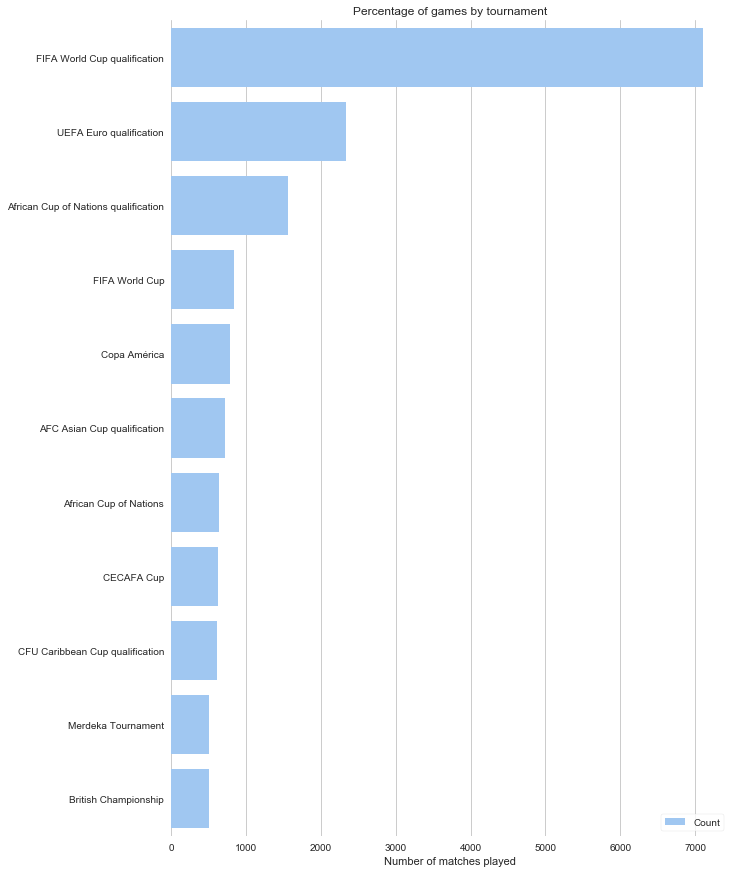

In [63]:
tournament_play_display = tournament_play[(tournament_play > 500) & (tournament_play < 10000)].dropna().sort_values(by='tournament', ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x='tournament', y=tournament_play_display.index, data=tournament_play_display, label='Count', color='b')

# Add legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set_title("Percentage of games by tournament")
ax.set(xlabel="Number of matches played")
sns.despine(left=True, bottom=True)

In [64]:
# Subset with only non-friendly games
results_unfriendly = results[results.tournament != 'Friendly']

In [65]:
count_match_home_unf = results_unfriendly.home_team.value_counts()
count_match_away_unf = results_unfriendly.away_team.value_counts()
count_match_unf = pd.DataFrame([count_match_home_unf, count_match_away_unf]).transpose().fillna(0)
count_match_unf['total'] = count_match_unf.home_team + count_match_unf.away_team
count_match_unf = count_match_unf.sort_values('total', ascending=False)

Despite the number of countries with a number of international games higher than 500, only eight of them have more than 500 official matches. There are three south american countries: Argentina, Uruguay and Brazil. There are three european countries, all of them to be part of the United Kingdom: England, Scotland and Northern Ireland. Finally, two of them are asian: Korea Republic and Thailand.

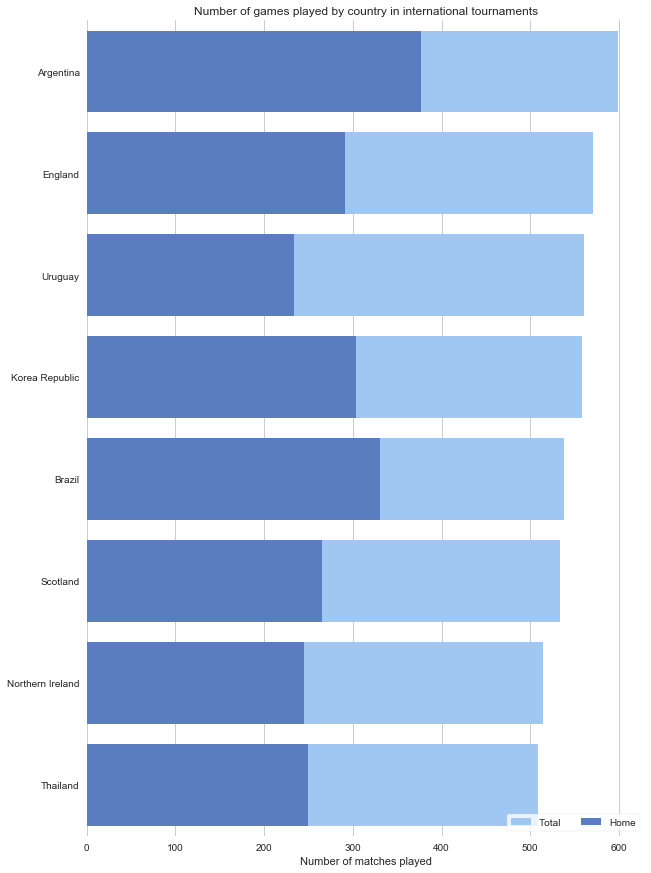

In [66]:
count_match_display_unf = count_match_unf[count_match_unf.total > 500]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x='total', y=count_match_display_unf.index, data=count_match_display_unf, label='Total', color='b')

# Plot the home match 
sns.set_color_codes("muted")
sns.barplot(x="home_team", y=count_match_display_unf.index, data=count_match_display_unf, label='Home', color='b')

# Add legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_title("Number of games played by country in international tournaments")
ax.set(xlabel="Number of matches played")
sns.despine(left=True, bottom=True)

## Build a report for a country

In [67]:
def get_opponent(data, country):
    if data.home_team == country:
        opponent = data.away_team
    else:
        opponent = data.home_team
        
    return(opponent)

def get_scores(data, country):
    if data.home_team == country:
        score = data.home_score
        score_opponent = data.away_score
    else:
        score = data.away_score
        score_opponent = data.home_score
    
    result = pd.Series([score, score_opponent])
    return(result)

def get_result(data):
    if data.score > data.score_opponent:
        result = 'W'
    elif data.score < data.score_opponent:
        result = 'L'
    else:
        result = 'T'
    
    return(result)

def get_history(data, country):
    
    opponents = data.apply(get_opponent, country = country, axis=1).rename('opponents')
    scores = data.apply(get_scores, country = country, axis=1).rename(columns={0: 'score', 1: 'score_opponent'})
    result = scores.apply(get_result, axis=1).rename('result')
    data = pd.concat([data, opponents, scores, result], axis=1)
    
    results_count = data.groupby(['opponents', 'result'], as_index=False).size().reset_index().pivot_table(columns='result', index='opponents', fill_value=0)
    results_count.columns = results_count.columns.droplevel().rename('')
    
    goals = data.groupby(['opponents']).mean().round(2)[['score', 'score_opponent']]
    first_match = data.groupby(['opponents']).first()[['date']]
    
    resume = pd.concat([results_count, goals, first_match], axis=1)
    
    return(resume)

def get_report(data, country):
    
    df = data[(data.home_team == country) | (data.away_team == country)]
    
    resume = get_history(df, country)
    resume.index.name = 'Opponents'
    resume.columns = ['Lost', 'Tie', 'Win', 'Mean Goals', 'Mean Goals Opponents', 'First Match Date']
    
    return(resume)

In [226]:
get_report(results, 'France')

,Lost,Tie,Win,Mean Goals,Mean Goals Opponents,First Match Date
Opponents,,,,,,
Albania,1,1,5,2.00,0.43,1990-11-17
Algeria,0,0,1,4.00,1.00,2001-10-06
Andorra,0,0,3,2.33,0.00,1998-10-14
Argentina,6,3,2,0.64,1.09,1930-07-15
Armenia,0,0,5,2.80,0.40,1996-06-05
Australia,1,1,2,2.00,0.50,1994-05-26
Austria,9,2,12,1.70,1.74,1925-04-19
Azerbaijan,0,0,1,10.00,0.00,1995-09-06
Belarus,1,2,3,1.67,1.00,2010-09-03


In [228]:
get_report(results, 'France').loc['Belgium', :]

Lost                                     30
Tie                                      19
Win                                      24
Mean Goals                             1.74
Mean Goals Opponents                   2.19
First Match Date        1904-05-01 00:00:00
Name: Belgium, dtype: object

## Predict the results of the 2018 World Cup

In [69]:
# Load the ranking data
ranking = pd.read_csv('./ranking.csv', sep=',')
ranking = ranking.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg', 'rank_date']]
ranking = ranking.replace({"IR Iran": "Iran"})
ranking['rank_date'] = pd.to_datetime(ranking['rank_date'])

In [97]:
# Create the rank for every day since 08-08-1993
ranking = ranking.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

In [103]:
# Merge the results and the ranking dataframes
matches = results.merge(ranking, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])

matches = matches.merge(ranking, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [108]:
# Remove the useless/redundant columns
matches.drop(columns=['city', 'country', 'day', 'month', 'year', 
                      'country_full_home', 'country_abrv_home', 'rank_date_home',
                      'country_full_away', 'country_abrv_away', 'rank_date_away'],
            axis=1, inplace=True)

In [110]:
# Remove all the Friendly matches
matches = matches[matches.tournament != 'Friendly']

In [160]:
# Create some features
matches = matches.assign(score_difference = matches['home_score'] - matches['away_score'])
matches = matches.assign(rank_difference = matches['rank_home'] - matches['rank_away'])
matches = matches.assign(point_difference = matches['cur_year_avg_home'] - matches['cur_year_avg_away'])

matches['results'] = np.where(matches['score_difference'] > 0, 1, np.where(matches['score_difference'] < 0, -1, 0))

In [177]:
# Build the model
X, y = matches.loc[:, ['neutral', 'rank_home', 'rank_difference', 'point_difference']], matches.loc[:, 'results']

# Split X, y into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform logistic regression
logreg = linear_model.LogisticRegression(C=1e-5)
model = logreg.fit(X_train, y_train)

# Predict the results on the test set
pred = model.predict(X_test)

print("The accuracy score is {:.2f}.".format(metrics.accuracy_score(pred, y_test)))

The accuracy score is 0.60.


In [184]:
# Load the World Cup data
world_cup = pd.read_csv('./world_cup.csv')
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({'IRAN': 'Iran',
                               'Costarica': 'Costa Rica',
                               'Porugal': 'Portugal',
                               'Columbia': 'Colombia',
                               'Korea': 'Korea Republic'})
world_cup = world_cup.set_index('Team')

In [187]:
# Build a dataframe contining the ranking of the World Cup contenders
world_cup_ranking = ranking.loc[(ranking['rank_date'] == ranking['rank_date'].max()) & 
                                    ranking['country_full'].isin(world_cup.index.unique())]
world_cup_ranking = world_cup_ranking.set_index(['country_full'])

In [221]:
# Predict the World Cup results
for group in world_cup['Group'].unique():
    # Print the group
    print("Results for the group {}:".format(group))
    for home, away in itertools.combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        # Print the the current match
        print("\t{} vs. {}: ".format(home, away), end='\n')
        
        # Build the dataframe to predict the match-up
        match = pd.DataFrame(np.array([[True, np.nan, np.nan, np.nan]]), columns=X_test.columns)
        
        # Do they play on a neutral field?
        if(home == 'Russia'):
            match['neutral'] = False
            
        # Consider the rank for the home team
        match['rank_home'] = world_cup_ranking.loc[home, 'rank']
        
        # Consider the difference of rank
        match['rank_difference'] = match['rank_home'] - world_cup_ranking.loc[away, 'rank']
        
        # Consider the difference of points
        match['point_difference'] = world_cup_ranking.loc[home, 'cur_year_avg'] - world_cup_ranking.loc[away, 'cur_year_avg']
        
        # Predict the probabilities for the game
        prob = model.predict_proba(match)
        
        print('\t\t{} wins with probability {:.2f}'.format(home, prob[:,2][0]))
        print('\t\t{} wins with probability {:.2f}'.format(away, prob[:,0][0]))
        print('\t\tIt is a draw with probability {:.2f}'.format(prob[:,1][0]))

Results for the group A:
	Russia vs. Saudi Arabia: 
		Russia wins with probability 0.44
		Saudi Arabia wins with probability 0.30
		It is a draw with probability 0.26
	Russia vs. Egypt: 
		Russia wins with probability 0.33
		Egypt wins with probability 0.38
		It is a draw with probability 0.28
	Russia vs. Uruguay: 
		Russia wins with probability 0.22
		Uruguay wins with probability 0.48
		It is a draw with probability 0.31
	Saudi Arabia vs. Egypt: 
		Saudi Arabia wins with probability 0.34
		Egypt wins with probability 0.38
		It is a draw with probability 0.28
	Saudi Arabia vs. Uruguay: 
		Saudi Arabia wins with probability 0.22
		Uruguay wins with probability 0.48
		It is a draw with probability 0.30
	Egypt vs. Uruguay: 
		Egypt wins with probability 0.28
		Uruguay wins with probability 0.41
		It is a draw with probability 0.31
Results for the group B:
	Portugal vs. Spain: 
		Portugal wins with probability 0.35
		Spain wins with probability 0.32
		It is a draw with probability 0.33
	P